<a href="https://colab.research.google.com/github/YucaiL/MachineL/blob/main/ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas_profiling as ppf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
from scipy.stats import norm
from scipy import stats
import sys
sys.path.append("..")
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)
warnings.filterwarnings('ignore')

1.8.1+cu101


In [ ]:
'''!pip install torch\
!pip install d2lzh_pytorch \
!pip install xgboost \
!pip install lightgbm'''
'''!pip install pandas-profiling'''

'!pip install pandas-profiling'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
df_train_ID = df_train['ID']
df_test_ID = df_test['ID']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("ID", axis = 1, inplace = True)
df_test.drop("ID", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(df_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (2051, 81) 
The test data size before dropping Id feature is : (879, 80) 

The train data size after dropping Id feature is : (2051, 80) 
The test data size after dropping Id feature is : (879, 79) 


In [ ]:
# The judgement tools
def rmse(y_true, y_pred):
    """Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Visualize and describe data

In [ ]:
pd.set_option('display.max_columns', len(df_train.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
df_train.head()

,Paved Drive,BsmtExposure,BsmtUnfinishedArea,ProximityToMainRoad2,KitchenQuality,SaleCondition,LivingArea,Lot Config,FenceQuality,SaleType,HalfBaths,Neighborhood,HeatingQuality,LotFrontage,RoofMaterial,Exterior1,Foundation,HouseType,YearRemodelled,MasVnrArea,Misc Feature,GarageFinish,ExteriorQual,UtilitiesAvailable,HouseStyle,MasVnrType,FireplaceQuality,EnclosedPorchArea,BsmtCondition,PoolSize,BsmtHeight,BsmtFullBaths,ScreenPorchArea,Misc,BsmtFinishType2,TotalRooms,YearBuilt,YearSold,BsmtFinish2Area,PoolQuality,OpenPorchArea,Fireplaces,RoofType,Functional,ExteriorCond,GarageCondition,TotalBsmtArea,Electrical,SeasonPorchArea,LowQualityFinishArea,ProximityToMainRoad,BsmtHalfBaths,GarageQuality,WoodDeckArea,ZoningClass,Bedrooms,TypeOfAlleyAccess,FullBaths,OverallRating,BsmtFinishType1,TypeOfRoadAccess,MonthSold,GarageCars,Shape,Flatness,HeatingType,Central Air,SlopeOfProperty,Exterior2,GarageArea,BsmtFinish1Area,Quality,GarageType,LotSize,Kitchens,GarageYearBuilt,BuildingClass,2ndFloorArea,1stFloorArea,SalePrice
0,Y,No,2073.0,Norm,TA,Normal,1866,Inside,NaN,WD,0,NAmes,Ex,76.0,CompShg,Wd Sdng,PConc,Duplex,1958,657.0,NaN,Unf,TA,AllPub,1Story,BrkFace,NaN,0,TA,0,TA,0.0,0,0,Unf,8,1958,2009,0.0,NaN,0,0,Hip,Typ,TA,Fa,2073.0,SBrkr,0,0,Norm,0.0,TA,0,RL,4,NaN,2,4,Unf,Pave,12,2.0,Reg,Lvl,GasA,Y,Gtl,Wd Sdng,495.0,0.0,5,Detchd,9482,2,1958.0,90,252,2910,165856
1,Y,No,1624.0,Norm,Ex,Partial,1428,FR2,NaN,New,0,Somerst,Ex,91.0,CompShg,VinylSd,PConc,1Fam,2008,256.0,NaN,RFn,Gd,AllPub,1Story,Stone,NaN,0,TA,0,Gd,0.0,0,0,Unf,6,2008,2008,0.0,NaN,60,0,Gable,Typ,TA,TA,1624.0,SBrkr,0,0,Norm,0.0,TA,0,RL,3,NaN,2,5,Unf,Pave,7,2.0,IR1,Lvl,GasA,Y,Gtl,VinylSd,554.0,0.0,7,Attchd,12274,1,2008.0,20,252,2472,267804
2,Y,Mn,1007.0,Norm,Gd,Abnorml,2259,Corner,MnPrv,COD,0,Crawfor,TA,NaN,CompShg,Wd Sdng,CBlock,1Fam,1953,184.0,NaN,Unf,TA,AllPub,1Story,BrkFace,Gd,192,TA,0,Gd,1.0,0,0,Rec,7,1953,2007,910.0,NaN,120,2,Hip,Typ,Gd,TA,2016.0,SBrkr,0,0,Norm,0.0,TA,166,RL,3,NaN,2,5,ALQ,Pave,10,2.0,Reg,Bnk,GasA,Y,Gtl,Wd Sdng,450.0,99.0,6,Basment,21000,1,1953.0,20,252,3303,256056
3,Y,No,582.0,Norm,Gd,Normal,1737,Corner,NaN,WD,1,SawyerW,Gd,75.0,CompShg,HdBoard,PConc,1Fam,1992,0.0,NaN,Fin,Gd,AllPub,2Story,None,NaN,0,TA,0,Gd,0.0,0,0,Unf,7,1992,2008,0.0,NaN,85,0,Gable,Typ,TA,TA,1043.0,SBrkr,0,0,Norm,1.0,TA,192,RL,3,NaN,2,5,GLQ,Pave,5,2.0,Reg,Lvl,GasA,Y,Gtl,HdBoard,506.0,461.0,7,Attchd,8285,1,1992.0,60,1145,1888,209856
4,Y,No,1299.0,Artery,TA,Abnorml,1092,FR2,NaN,WD,0,Mitchel,Ex,77.0,CompShg,VinylSd,PConc,1Fam,2008,0.0,NaN,NaN,TA,AllPub,1Story,None,NaN,0,TA,0,Gd,0.0,0,0,Unf,5,2007,2008,0.0,NaN,52,0,Gable,Typ,TA,NaN,1299.0,SBrkr,0,0,Feedr,0.0,NaN,0,RL,2,NaN,1,5,Unf,Pave,2,0.0,Reg,Lvl,GasA,Y,Gtl,VinylSd,0.0,0.0,5,NaN,9278,1,NaN,20,252,2136,177956


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Paved Drive           2051 non-null   object 
 1   BsmtExposure          1996 non-null   object 
 2   BsmtUnfinishedArea    2051 non-null   float64
 3   ProximityToMainRoad2  2051 non-null   object 
 4   KitchenQuality        2051 non-null   object 
 5   SaleCondition         2051 non-null   object 
 6   LivingArea            2051 non-null   int64  
 7   Lot Config            2051 non-null   object 
 8   FenceQuality          402 non-null    object 
 9   SaleType              2051 non-null   object 
 10  HalfBaths             2051 non-null   int64  
 11  Neighborhood          2051 non-null   object 
 12  HeatingQuality        2051 non-null   object 
 13  LotFrontage           1708 non-null   float64
 14  RoofMaterial          2051 non-null   object 
 15  Exterior1            

In [ ]:
#pandas_profiling.ProfileReport(df_train)- a time costing block

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

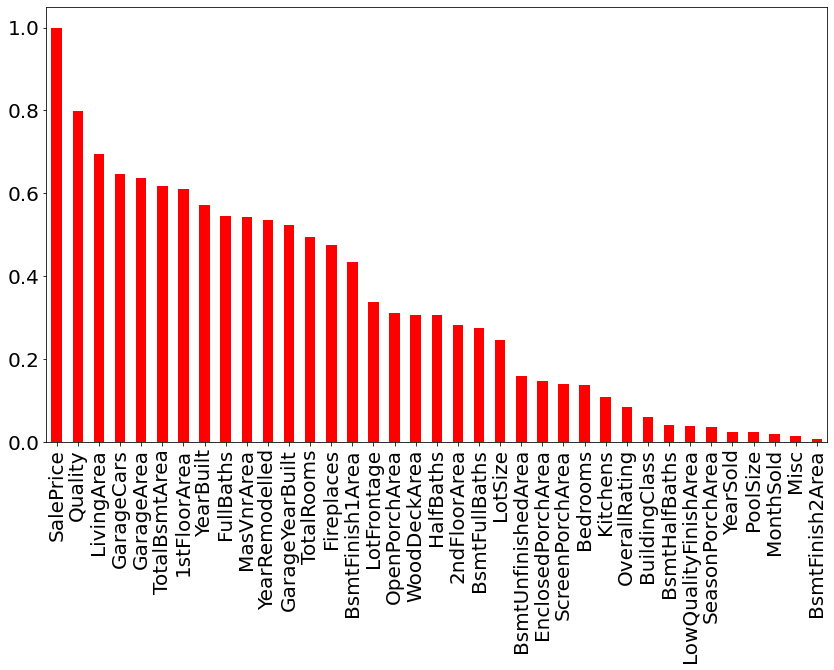

In [ ]:
fig = plt.figure(figsize=(14,8))
abs(df_train.corr()['SalePrice']).sort_values(ascending=False).plot.bar(color='r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
#sns.distplot(df_train['SalePrice'],fit=norm)

In [ ]:
#sns.distplot(np.log(df_train['SalePrice']),fit=norm)

<Figure size 1440x1440 with 0 Axes>

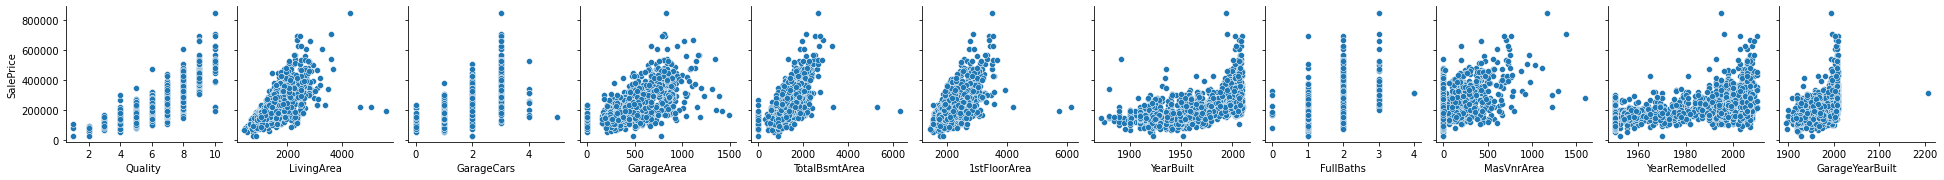

In [ ]:
x_col = ['Quality','LivingArea','GarageCars','GarageArea','TotalBsmtArea','1stFloorArea',\
         'YearBuilt','FullBaths','MasVnrArea','YearRemodelled','GarageYearBuilt']

figure = plt.figure(figsize=(20,20))
sns.pairplot(x_vars = x_col, y_vars = ['SalePrice'], \
            data = df_train, dropna = True)
plt.show()

### Data Preprocessing

In [ ]:
#Let's drop the abnormal value
df_train.drop(df_train[(df_train['Quality']>10) & (df_train['SalePrice']<300000)].index,inplace=True)
df_train.drop(df_train[(df_train['LivingArea']>4000) & (df_train['SalePrice']<300000)].index,inplace=True)
df_train.drop(df_train[(df_train['GarageCars']>4) & (df_train['SalePrice']<300000)].index,inplace=True)
df_train.drop(df_train[(df_train['TotalBsmtArea']>4000) & (df_train['SalePrice']<300000)].index,inplace=True)
df_train.drop(df_train[(df_train['1stFloorArea']>5000) & (df_train['SalePrice']<400000)].index,inplace=True)
df_train.drop(df_train[(df_train['YearBuilt']<1900) & (df_train['SalePrice']>400000)].index,inplace=True)
df_train.drop(df_train[(df_train['FullBaths']<2) & (df_train['SalePrice']>600000)].index,inplace=True)
df_train.drop(df_train[(df_train['MasVnrArea']>1000) & (df_train['SalePrice']<400000)].index,inplace=True)
df_train.drop(df_train[(df_train['GarageYearBuilt']>2100) & (df_train['SalePrice']<400000)].index,inplace=True)

#Reset the index
df_train.reset_index(drop = True, inplace = True)


### Deal with the 'SalePrice'


 mu = 214552.34 and sigma = 86686.48



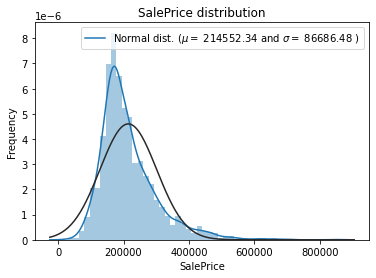

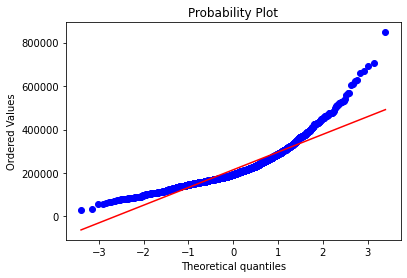

In [ ]:
# Create a function to get the distribution picture
def plt_distribution(data, obj_col):
    sns.distplot(data[obj_col] , fit=norm);

    # get the mean and standard deviation of the data
    (mu, sigma) = norm.fit(data[obj_col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    # draw the distribution curve
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('SalePrice distribution')

    # Plot the picture
    fig = plt.figure()
    res = stats.probplot(data[obj_col], plot=plt)
    plt.show()
plt_distribution(df_train, 'SalePrice')        # the original saleprice


 mu = 12.21 and sigma = 0.37



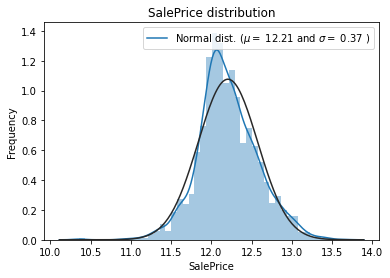

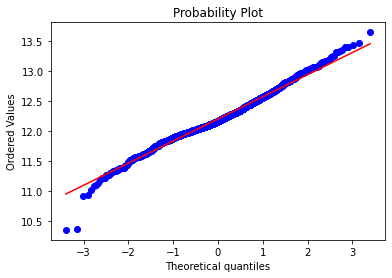

In [ ]:
# Transform the saleprice into a log normal one
df_train["SalePrice"] = np.log1p(df_train["SalePrice"]) 
plt_distribution(df_train, 'SalePrice')

### Combine the whole data

In [ ]:
all_data=pd.concat([df_train,df_test],axis=0)
all_data.reset_index(drop=True, inplace=True)  # Reset the index

display(df_train.shape)
display(df_test.shape)
display(all_data.shape) # Mark down the index to help us split them later

(2041, 80)

(879, 79)

(2920, 80)

In [ ]:
# See the percentage of null value
count = all_data.isnull().sum().sort_values(ascending=False)
ratio = count / len(all_data)
nulldata = pd.concat([count,ratio], axis = 1, keys = ['count','ratio']) # make it visulize
nulldata[nulldata['ratio']>0]

,count,ratio
PoolQuality,2909,0.996233
Misc Feature,2815,0.964041
TypeOfAlleyAccess,2723,0.932534
FenceQuality,2350,0.804795
FireplaceQuality,1421,0.486644
SalePrice,879,0.301027
LotFrontage,490,0.167808
GarageYearBuilt,159,0.054452
GarageFinish,159,0.054452
GarageCondition,159,0.054452


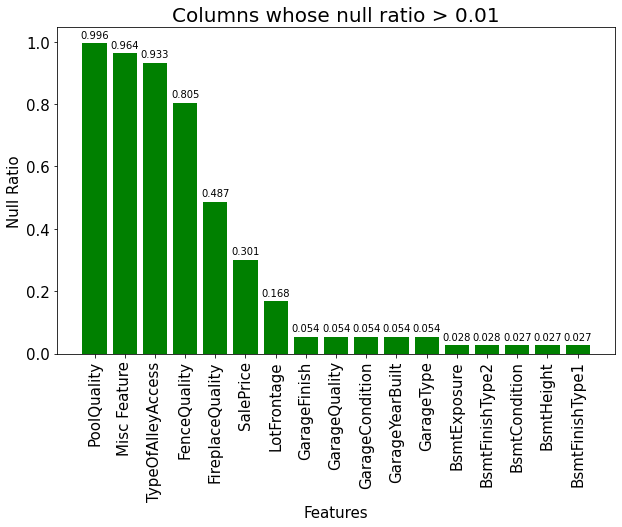

In [ ]:
def null_hist(data):                             # A function to visualize the data
    cols = list(data.columns)
    the_null_percents = []
    for col in cols:
        # print(col)
        the_null_percent = np.uint8(data[col].isnull()).sum()/len(data[col].values)       # get the ratio of the null data
        # print(the_na_percent)

        the_null_percents.append(the_null_percent)

    plot_data = pd.Series(the_null_percents, index = cols)    # make a series of null data
    plot_data = plot_data[plot_data.values>0.01]              # we only focus on the null ratio bigger than 0.01
    plot_data = plot_data.sort_values(ascending=False)        # descending ranking
    plot_data = plot_data[plot_data.values != 0]              # get the data which is positive

    ## linear plot
    plot_x = plot_data.index
    plot_y = plot_data.values

    plt.figure(figsize=(10,6))
    # plt.axis(ymin=0,ymax=1)

    plt.bar(plot_x, plot_y, color='g')

    #plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False       # make the negative sign shown

    plt.title("Columns whose null ratio > 0.01",fontsize=20)
    plt.xlabel("Features",fontsize=15)
    plt.ylabel("Null Ratio",fontsize=15)

    plt.tick_params(labelsize = 15)         
    plt.xticks(rotation = 90)               

    for a,b in zip(plot_x,plot_y.round(3)):                    #show the number of the plot
        plt.text(a,b+0.01,b,ha='center',va='bottom',fontsize=10) 

    plt.show() 

null_hist(all_data)

# How to fill the NaN?
### for object type value, NaN means there is no such a kind of feature
### for Number type value, NaN means the feature has a zero value or just missing.

In [ ]:
str_cols = ["PoolQuality" , "Misc Feature", "TypeOfAlleyAccess", "FenceQuality", "FireplaceQuality", "GarageType", "GarageFinish", "GarageQuality", "GarageCondition",  \
            "BsmtCondition", "BsmtExposure", "BsmtFinishType1", "BsmtFinishType2", "MasVnrType"]
for col in str_cols:
    all_data[col].fillna("None",inplace=True)
    
del str_cols, col

In [ ]:
num_cols=["GarageYearBuilt","BsmtHeight","MasVnrArea","BsmtFullBaths","BsmtHalfBaths",\
          "BsmtFinish1Area","BsmtFinish2Area","GarageArea","BsmtUnfinishedArea","TotalBsmtArea","GarageCars"]

for col in num_cols:
    all_data[col].fillna(0, inplace=True)
    
del num_cols, col

In [ ]:
other_cols = [ "Electrical"]
for col in other_cols:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)
    
del other_cols, col

In [ ]:
all_data["LotFrontage"] = all_data.groupby("HouseType")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
count=all_data.isnull().sum().sort_values(ascending=False)
ratio=count/len(all_data)
nulldata=pd.concat([count,ratio],axis=1,keys=['count','ratio'])
del count, ratio
nulldata[nulldata.ratio>0]

,count,ratio
SalePrice,879,0.301027


# No NaN values anymore

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder                    # To solve the ordinal variable
from sklearn.preprocessing import RobustScaler, StandardScaler    # Scaler 
from sklearn.pipeline import Pipeline, make_pipeline              # Pipeline
from scipy.stats import skew                                 
from scipy.special import boxcox1p                           # box-cox transform
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [ ]:
# For oridnal variable, they are indifferent
np.unique(all_data['ExteriorQual'])

array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object)

In [ ]:
def custom_coding(x):
    if(x=='Ex'):
        r = 0
    elif(x=='Gd'):
        r = 1
    elif(x=='TA'):
        r = 2
    elif(x=='Fa'):
        r = 3
    elif(x=='None'):
        r = 4
    else:
        r = 5
    return r
cols = ['KitchenQuality','HeatingQuality','ExteriorQual','BsmtCondition','BsmtHeight','ExteriorCond','GarageCondition','GarageQuality','PoolQuality','FireplaceQuality']
for col in cols:
    all_data[col] = all_data[col].apply(custom_coding)
    
del cols, col

In [ ]:
# Some variables have no meaning linked to its values like years and type
cols = ['GarageYearBuilt','Exterior2', 'MonthSold', 'OverallRating', "FullBaths", "BsmtFullBaths", "BsmtHalfBaths", "LowQualityFinishArea",\
        "SeasonPorchArea", "Electrical", "Functional","YearSold", "YearBuilt", "YearRemodelled"]

for col in cols:
    all_data[col] = all_data[col].astype(str) 
    
del cols, col

In [ ]:
all_data.head()

,Paved Drive,BsmtExposure,BsmtUnfinishedArea,ProximityToMainRoad2,KitchenQuality,SaleCondition,LivingArea,Lot Config,FenceQuality,SaleType,HalfBaths,Neighborhood,HeatingQuality,LotFrontage,RoofMaterial,Exterior1,Foundation,HouseType,YearRemodelled,MasVnrArea,Misc Feature,GarageFinish,ExteriorQual,UtilitiesAvailable,HouseStyle,MasVnrType,FireplaceQuality,EnclosedPorchArea,BsmtCondition,PoolSize,BsmtHeight,BsmtFullBaths,ScreenPorchArea,Misc,BsmtFinishType2,TotalRooms,YearBuilt,YearSold,BsmtFinish2Area,PoolQuality,OpenPorchArea,Fireplaces,RoofType,Functional,ExteriorCond,GarageCondition,TotalBsmtArea,Electrical,SeasonPorchArea,LowQualityFinishArea,ProximityToMainRoad,BsmtHalfBaths,GarageQuality,WoodDeckArea,ZoningClass,Bedrooms,TypeOfAlleyAccess,FullBaths,OverallRating,BsmtFinishType1,TypeOfRoadAccess,MonthSold,GarageCars,Shape,Flatness,HeatingType,Central Air,SlopeOfProperty,Exterior2,GarageArea,BsmtFinish1Area,Quality,GarageType,LotSize,Kitchens,GarageYearBuilt,BuildingClass,2ndFloorArea,1stFloorArea,SalePrice
0,Y,No,2073.0,Norm,2,Normal,1866,Inside,None,WD,0,NAmes,0,76.0,CompShg,Wd Sdng,PConc,Duplex,1958,657.0,None,Unf,2,AllPub,1Story,BrkFace,4,0,2,0,2,0.0,0,0,Unf,8,1958,2009,0.0,4,0,0,Hip,Typ,2,3,2073.0,SBrkr,0,0,Norm,0.0,2,0,RL,4,None,2,4,Unf,Pave,12,2.0,Reg,Lvl,GasA,Y,Gtl,Wd Sdng,495.0,0.0,5,Detchd,9482,2,1958.0,90,252,2910,12.018881
1,Y,No,1624.0,Norm,0,Partial,1428,FR2,None,New,0,Somerst,0,91.0,CompShg,VinylSd,PConc,1Fam,2008,256.0,None,RFn,1,AllPub,1Story,Stone,4,0,2,0,1,0.0,0,0,Unf,6,2008,2008,0.0,4,60,0,Gable,Typ,2,2,1624.0,SBrkr,0,0,Norm,0.0,2,0,RL,3,None,2,5,Unf,Pave,7,2.0,IR1,Lvl,GasA,Y,Gtl,VinylSd,554.0,0.0,7,Attchd,12274,1,2008.0,20,252,2472,12.498014
2,Y,Mn,1007.0,Norm,1,Abnorml,2259,Corner,MnPrv,COD,0,Crawfor,2,70.0,CompShg,Wd Sdng,CBlock,1Fam,1953,184.0,None,Unf,2,AllPub,1Story,BrkFace,1,192,2,0,1,1.0,0,0,Rec,7,1953,2007,910.0,4,120,2,Hip,Typ,1,2,2016.0,SBrkr,0,0,Norm,0.0,2,166,RL,3,None,2,5,ALQ,Pave,10,2.0,Reg,Bnk,GasA,Y,Gtl,Wd Sdng,450.0,99.0,6,Basment,21000,1,1953.0,20,252,3303,12.453155
3,Y,No,582.0,Norm,1,Normal,1737,Corner,None,WD,1,SawyerW,1,75.0,CompShg,HdBoard,PConc,1Fam,1992,0.0,None,Fin,1,AllPub,2Story,None,4,0,2,0,1,0.0,0,0,Unf,7,1992,2008,0.0,4,85,0,Gable,Typ,2,2,1043.0,SBrkr,0,0,Norm,1.0,2,192,RL,3,None,2,5,GLQ,Pave,5,2.0,Reg,Lvl,GasA,Y,Gtl,HdBoard,506.0,461.0,7,Attchd,8285,1,1992.0,60,1145,1888,12.254182
4,Y,No,1299.0,Artery,2,Abnorml,1092,FR2,None,WD,0,Mitchel,0,77.0,CompShg,VinylSd,PConc,1Fam,2008,0.0,None,None,2,AllPub,1Story,None,4,0,2,0,1,0.0,0,0,Unf,5,2007,2008,0.0,4,52,0,Gable,Typ,2,4,1299.0,SBrkr,0,0,Feedr,0.0,4,0,RL,2,None,1,5,Unf,Pave,2,0.0,Reg,Lvl,GasA,Y,Gtl,VinylSd,0.0,0.0,5,None,9278,1,0.0,20,252,2136,12.089297


In [ ]:
#Using the LabelEncoder to code the year variable
str_cols = ['MonthSold', 'YearSold', 'YearBuilt', 'YearRemodelled', 'GarageYearBuilt']
for col in str_cols:
    all_data[col] = LabelEncoder().fit_transform(all_data[col])
    
del col,str_cols

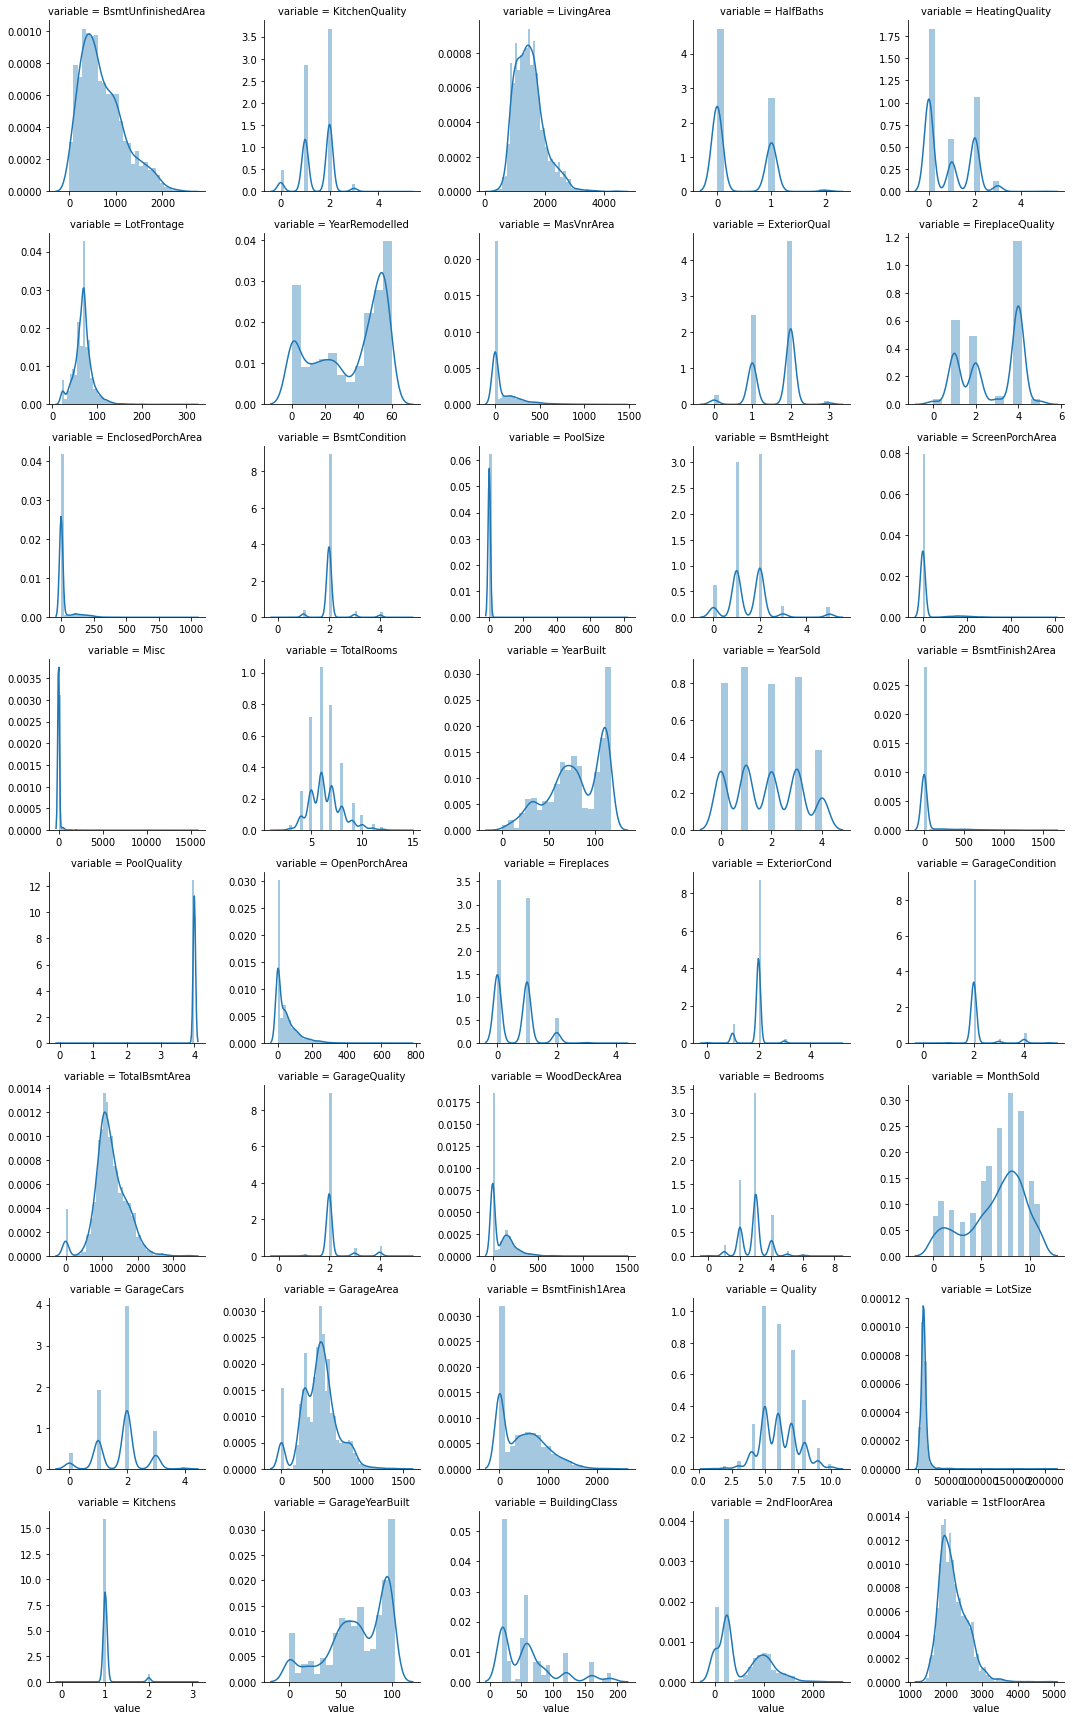

In [ ]:
num_features = all_data.select_dtypes(include=['int64','float64','int32']).copy()
num_features.drop(['SalePrice'],axis=1,inplace=True)               #don't include the saleprice of house

num_feature_names = list(num_features.columns)

num_features_data = pd.melt(all_data, value_vars=num_feature_names)
g = sns.FacetGrid(num_features_data, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

In [ ]:
from scipy.stats import norm, skew       
skewed_feats = all_data[num_feature_names].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness[skewness["Skew"].abs()>0.75]

,Skew
Misc,22.194651
PoolSize,17.832806
LotSize,13.194688
Kitchens,4.303106
EnclosedPorchArea,4.008702
ScreenPorchArea,3.971578
BsmtFinish2Area,3.945662
GarageCondition,3.161729
GarageQuality,2.866817
OpenPorchArea,2.499183


In [ ]:
skew_cols = list(skewness[skewness["Skew"].abs()>1].index)
for col in skew_cols:
    #all_data[col] = boxcox1p(all_data[col], 0.15)                                  # Another Box-cox transform
    all_data[col] = np.log1p(all_data[col])                                                  # the feature log transform
    
del num_features, num_feature_names, num_features_data, g, skewed_feats, col, skew_cols      

In [ ]:
#Dummy Variables
all_data = pd.get_dummies(all_data) 
all_data.head()

,BsmtUnfinishedArea,KitchenQuality,LivingArea,HalfBaths,HeatingQuality,LotFrontage,YearRemodelled,MasVnrArea,ExteriorQual,FireplaceQuality,EnclosedPorchArea,BsmtCondition,PoolSize,BsmtHeight,ScreenPorchArea,Misc,TotalRooms,YearBuilt,YearSold,BsmtFinish2Area,PoolQuality,OpenPorchArea,Fireplaces,ExteriorCond,GarageCondition,TotalBsmtArea,GarageQuality,WoodDeckArea,Bedrooms,MonthSold,GarageCars,GarageArea,BsmtFinish1Area,Quality,LotSize,Kitchens,GarageYearBuilt,BuildingClass,2ndFloorArea,1stFloorArea,...,Shape_Reg,Flatness_Bnk,Flatness_HLS,Flatness_Low,Flatness_Lvl,HeatingType_Floor,HeatingType_GasA,HeatingType_GasW,HeatingType_Grav,HeatingType_OthW,HeatingType_Wall,Central Air_N,Central Air_Y,SlopeOfProperty_Gtl,SlopeOfProperty_Mod,SlopeOfProperty_Sev,Exterior2_AsbShng,Exterior2_AsphShn,Exterior2_Brk Cmn,Exterior2_BrkFace,Exterior2_CBlock,Exterior2_CmentBd,Exterior2_HdBoard,Exterior2_ImStucc,Exterior2_MetalSd,Exterior2_Other,Exterior2_Plywood,Exterior2_PreCast,Exterior2_Stone,Exterior2_Stucco,Exterior2_VinylSd,Exterior2_Wd Sdng,Exterior2_Wd Shng,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,2073.0,2,1866,0,0,4.343805,8,6.489205,2,4,0.00000,1.098612,0.0,1.098612,0.0,0.0,8,65,3,0.000000,1.609438,0.000000,0,2,1.386294,2073.0,1.098612,0.000000,4,3,2.0,495.0,0.0,5,9.157256,1.098612,50,4.510860,252,2910,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,1624.0,0,1428,0,0,4.521789,58,5.549076,1,4,0.00000,1.098612,0.0,0.693147,0.0,0.0,6,115,2,0.000000,1.609438,4.110874,0,2,1.098612,1624.0,1.098612,0.000000,3,9,2.0,554.0,0.0,7,9.415320,0.693147,100,3.044522,252,2472,...,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1007.0,1,2259,0,2,4.262680,3,5.220356,2,1,5.26269,1.098612,0.0,0.693147,0.0,0.0,7,60,1,6.814543,1.609438,4.795791,2,1,1.098612,2016.0,1.098612,5.117994,3,1,2.0,450.0,99.0,6,9.952325,0.693147,45,3.044522,252,3303,...,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,582.0,1,1737,1,1,4.330733,42,0.000000,1,4,0.00000,1.098612,0.0,0.693147,0.0,0.0,7,99,2,0.000000,1.609438,4.454347,0,2,1.098612,1043.0,1.098612,5.262690,3,7,2.0,506.0,461.0,7,9.022323,0.693147,84,4.110874,1145,1888,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1299.0,2,1092,0,0,4.356709,58,0.000000,2,4,0.00000,1.098612,0.0,0.693147,0.0,0.0,5,114,2,0.000000,1.609438,3.970292,0,2,1.609438,1299.0,1.609438,0.000000,2,4,0.0,0.0,0.0,5,9.135509,0.693147,0,3.044522,252,2136,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
all_data.info()
'''No more object type value'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Columns: 354 entries, BsmtUnfinishedArea to GarageType_None
dtypes: float64(23), int64(18), uint8(313)
memory usage: 1.8 MB


'No more object type value'

In [ ]:
all_data.shape

(2920, 354)

,BsmtUnfinishedArea,KitchenQuality,LivingArea,HalfBaths,HeatingQuality,LotFrontage,YearRemodelled,MasVnrArea,ExteriorQual,FireplaceQuality,EnclosedPorchArea,BsmtCondition,PoolSize,BsmtHeight,ScreenPorchArea,Misc,TotalRooms,YearBuilt,YearSold,BsmtFinish2Area,PoolQuality,OpenPorchArea,Fireplaces,ExteriorCond,GarageCondition,TotalBsmtArea,GarageQuality,WoodDeckArea,Bedrooms,MonthSold,GarageCars,GarageArea,BsmtFinish1Area,Quality,LotSize,Kitchens,GarageYearBuilt,BuildingClass,2ndFloorArea,1stFloorArea,...,Shape_Reg,Flatness_Bnk,Flatness_HLS,Flatness_Low,Flatness_Lvl,HeatingType_Floor,HeatingType_GasA,HeatingType_GasW,HeatingType_Grav,HeatingType_OthW,HeatingType_Wall,Central Air_N,Central Air_Y,SlopeOfProperty_Gtl,SlopeOfProperty_Mod,SlopeOfProperty_Sev,Exterior2_AsbShng,Exterior2_AsphShn,Exterior2_Brk Cmn,Exterior2_BrkFace,Exterior2_CBlock,Exterior2_CmentBd,Exterior2_HdBoard,Exterior2_ImStucc,Exterior2_MetalSd,Exterior2_Other,Exterior2_Plywood,Exterior2_PreCast,Exterior2_Stone,Exterior2_Stucco,Exterior2_VinylSd,Exterior2_Wd Sdng,Exterior2_Wd Shng,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,2073.0,2,1866,0,0,4.343805,8,6.489205,2,4,0.00000,1.098612,0.0,1.098612,0.000000,0.0,8,65,3,0.000000,1.609438,0.000000,0,2,1.386294,2073.0,1.098612,0.000000,4,3,2.0,495.0,0.0,5,9.157256,1.098612,50,4.510860,252,2910,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,1624.0,0,1428,0,0,4.521789,58,5.549076,1,4,0.00000,1.098612,0.0,0.693147,0.000000,0.0,6,115,2,0.000000,1.609438,4.110874,0,2,1.098612,1624.0,1.098612,0.000000,3,9,2.0,554.0,0.0,7,9.415320,0.693147,100,3.044522,252,2472,...,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1007.0,1,2259,0,2,4.262680,3,5.220356,2,1,5.26269,1.098612,0.0,0.693147,0.000000,0.0,7,60,1,6.814543,1.609438,4.795791,2,1,1.098612,2016.0,1.098612,5.117994,3,1,2.0,450.0,99.0,6,9.952325,0.693147,45,3.044522,252,3303,...,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,582.0,1,1737,1,1,4.330733,42,0.000000,1,4,0.00000,1.098612,0.0,0.693147,0.000000,0.0,7,99,2,0.000000,1.609438,4.454347,0,2,1.098612,1043.0,1.098612,5.262690,3,7,2.0,506.0,461.0,7,9.022323,0.693147,84,4.110874,1145,1888,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1299.0,2,1092,0,0,4.356709,58,0.000000,2,4,0.00000,1.098612,0.0,0.693147,0.000000,0.0,5,114,2,0.000000,1.609438,3.970292,0,2,1.609438,1299.0,1.609438,0.000000,2,4,0.0,0.0,0.0,5,9.135509,0.693147,0,3.044522,252,2136,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,610.0,2,1244,1,0,4.510860,7,0.000000,2,1,0.00000,1.098612,0.0,1.098612,0.000000,0.0,6,64,1,0.000000,1.609438,3.713572,2,2,1.098612,1451.0,1.098612,0.000000,3,7,1.0,336.0,841.0,6,9.391745,0.693147,49,3.044522,0,2288,...,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2916,543.0,2,1773,0,2,4.394449,42,4.653960,2,2,0.00000,1.098612,0.0,1.098612,4.976734,0.0,6,68,0,0.000000,1.609438,4.595120,2,2,1.098612,1520.0,1.098612,5.874931,3,10,2.0,418.0,977.0,6,9.287394,0.693147,53,3.044522,0,2817,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2917,688.0,3,1518,0,0,4.454347,57,0.000000,2,1,0.00000,1.098612,0.0,1.098612,0.000000,0.0,5,49,2,0.000000,1.609438,3.688879,2,2,1.609438,1787.0,1.609438,0.000000,2,0,0.0,0.0,1099.0,5,9.880782,0.693147,0,3.433987,0,2562,...,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2918,102.0,2,1183,0,2,4.394449,9,0.000000,2,4,0.00000,1.

In [ ]:
index_train = df_train.index
train = all_data[:max(index_train)+1]
test  = all_data[max(index_train)+1:]

### **First try of different models**

In [ ]:
y_train  = train["SalePrice"]

In [ ]:
xgb_train = train.copy()
xgb_test = test.copy()

[13:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


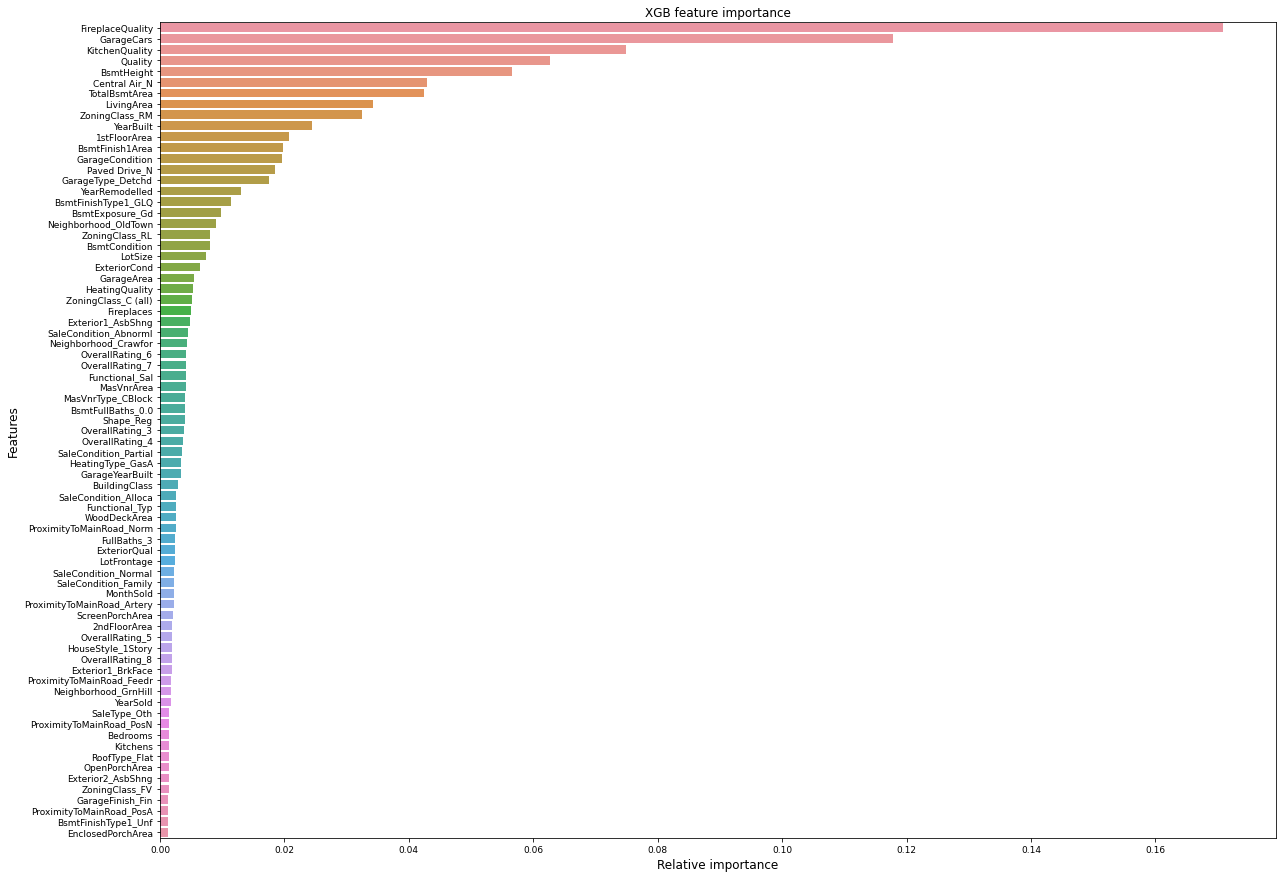

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, y_train)


# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [ ]:
xgb_train1 = train.copy()
xgb_test1 = test.copy()

from sklearn.feature_selection import SelectFromModel

xgb_feat_red = SelectFromModel(model,prefit=True)
# reduce estimation validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train1)
xgb_test = xgb_feat_red.transform(xgb_test1)
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

X_train:  (2041, 43) 
X_test:  (879, 43)


In [ ]:
from sklearn import model_selection

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

# X_train = predictor features for estimation dataset
# X_test = predictor variables for validation dataset
# Y_train = target variable for the estimation dataset
# Y_test = target variable for the estimation dataset

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1428, 43) 
X_test:  (613, 43) 
Y_train:  (1428,) 
Y_test:  (613,)


In [ ]:
# Import models 
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm packages imported!')

Algorithm packages imported!


In [ ]:
# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

Model selection packages imported!


In [ ]:
models = [KernelRidge(),ElasticNet(),Lasso(),GradientBoostingRegressor(),BayesianRidge(),LassoLarsIC(),RandomForestRegressor(),xgb.XGBRegressor()]
shuff =ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
# Create a DataFrame to store the results
columns = ['Name','Parameters','Train mean_squared_error','Test mean_squared_error']
before_model_compare = pd.DataFrame(columns=columns)

# Sklearn GO GO GO!







In [ ]:
# Trained and Stored
row_index=0
for alg in models:
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index,'Name'] = model_name
    before_model_compare.loc[row_index,'Parameters'] = str(alg.get_params())
    alg.fit(X_train,Y_train)
    # for cross_validation  but the results are negative,we need to convert it to postive,均方误差
    training_results = np.sqrt((-cross_val_score(alg,X_train,Y_train,cv=shuff,scoring='neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    before_model_compare.loc[row_index,"Train mean_squared_error"] = training_results*100
    before_model_compare.loc[row_index,'Test mean_squared_error'] = test_results*100
    row_index+=1
    print(row_index,model_name,"trained>>>>")

    
decimals = 3
before_model_compare['Train mean_squared_error'] = before_model_compare['Train mean_squared_error'].apply(lambda x:round(x,decimals))
before_model_compare['Test mean_squared_error'] = before_model_compare['Train mean_squared_error'].apply(lambda x:round(x,decimals))
before_model_compare

1 KernelRidge trained>>>>
2 ElasticNet trained>>>>
3 Lasso trained>>>>
4 GradientBoostingRegressor trained>>>>
5 BayesianRidge trained>>>>
6 LassoLarsIC trained>>>>
7 RandomForestRegressor trained>>>>
[13:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained>>>>


,Name,Parameters,Train mean_squared_error,Test mean_squared_error
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",29.554,29.554
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",14.058,14.058
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",14.712,14.712
3,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",10.566,10.566
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",9.946,9.946
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",10.173,10.173
6,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",11.681,11.681
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",10.811,10.811


In [ ]:
models = [KernelRidge(),ElasticNet(),Lasso(),GradientBoostingRegressor(),BayesianRidge(),LassoLarsIC(),RandomForestRegressor(),
         xgb.XGBRegressor()]
KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns=columns)
row_index= 0

for alg in models:
    gs_alg = GridSearchCV(alg,param_grid=params_grid[0],cv=shuff,scoring='neg_mean_squared_error',n_jobs=-1)
    params_grid.pop(0)
    
    
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index,'Name'] = model_name
    gs_alg.fit(X_train,Y_train)
    gs_best=gs_alg.best_estimator_
    after_model_compare.loc[row_index,"Parameters"] = str(gs_alg.best_params_)
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt((Y_test-gs_alg.predict(X_test)**2).mean())
    after_model_compare.loc[row_index,"Train mean_squared_error"] = after_training_results*100
    after_model_compare.loc[row_index,'Test mean_squared_error']= after_test_results*100
    row_index+=1
    print(row_index,model_name,"trained>>>>>")


    
decimals = 3
after_model_compare['Train mean_squared_error'] = after_model_compare['Train mean_squared_error'].apply(lambda x:round(x,decimals))
after_model_compare['Test mean_squared_error'] = after_model_compare['Train mean_squared_error'].apply(lambda x:round(x,decimals))
after_model_compare

1 KernelRidge trained>>>>>
2 ElasticNet trained>>>>>
3 Lasso trained>>>>>
4 GradientBoostingRegressor trained>>>>>
5 BayesianRidge trained>>>>>
6 LassoLarsIC trained>>>>>
7 RandomForestRegressor trained>>>>>
[13:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained>>>>>


,Name,Parameters,Train mean_squared_error,Test mean_squared_error
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",9.953,9.953
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",9.978,9.978
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",9.967,9.967
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",10.428,10.428
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",9.946,9.946
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",10.173,10.173
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",11.830,11.830
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",10.372,10.372


In [ ]:
models  = [KernelRidge(),ElasticNet(),Lasso(),GradientBoostingRegressor(),BayesianRidge(),LassoLarsIC(),RandomForestRegressor(),xgb.XGBRegressor()]
names = ['KernelRidge','ElasticNet','Lasso','GradientBoostingRegressor','BayesianRidge','LassoLarsIC','RandomForest','XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index= 0

for alg in models:
    gs_alg = GridSearchCV(alg,param_grid=params_grid[0],cv=shuff,scoring='neg_mean_squared_error',n_jobs=-1)
    params_grid.pop(0)
    gs_alg.fit(X_train,Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc= row_index,column=names[0],value=gs_best.predict(X_test))
    print(row_index+1,alg.__class__.__name__,"train done")
    stacked_test_train.insert(loc=row_index,column=names[0],value=gs_best.predict(xgb_test))
    print(row_index+1,alg.__class__.__name__,"test done")
    print("---"*50)
    names.pop(0)
    row_index+=1
    
print("done")

1 KernelRidge train done
1 KernelRidge test done
------------------------------------------------------------------------------------------------------------------------------------------------------
2 ElasticNet train done
2 ElasticNet test done
------------------------------------------------------------------------------------------------------------------------------------------------------
3 Lasso train done
3 Lasso test done
------------------------------------------------------------------------------------------------------------------------------------------------------
4 GradientBoostingRegressor train done
4 GradientBoostingRegressor test done
------------------------------------------------------------------------------------------------------------------------------------------------------
5 BayesianRidge train done
5 BayesianRidge test done
-------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
stacked_validation_train.drop('Lasso',axis=1,inplace=True)
stacked_test_train.drop('Lasso',axis=1,inplace=True)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler



meta_model = make_pipeline(RobustScaler(),Lasso(alpha=0.00001,copy_X=True,fit_intercept=True,normalize=False,precompute=False,
                                               max_iter=10000,tol=0.0001,selection='random',random_state=42))
meta_model.fit(stacked_validation_train,Y_test)
meta_model_pred= np.expm1(meta_model.predict(stacked_test_train))
print("meta_model done")

meta_model done


In [ ]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("done")
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
[13:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
done


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,295973.744228,295221.491948,300294.265833,299112.825442,295200.428248,293920.320751,300511.398662,300139.562500
1,242309.945409,241919.917877,243385.424592,236043.814767,243110.700517,243925.685942,238425.507757,238662.671875
2,135075.951550,134977.821157,129947.817741,115865.183634,134676.908821,134297.202645,124942.543682,124184.453125
3,171510.759555,171852.792690,170660.950911,176734.687405,171866.256045,172269.342773,179417.284279,174984.312500
4,158537.747553,159116.801185,158736.560618,166320.468064,158796.242684,159024.568519,160281.431398,165495.687500


In [ ]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['SalePrice'] = ensemble
submission.to_csv('final_submission_wu+li2.csv',index=False)

In [ ]:
ensemble =final_predictions['Bayesian Ridge']

submission = pd.DataFrame()
submission['SalePrice'] = ensemble
submission.to_csv('Bayesian Ridge3.csv',index=False)

# **Below is what we finally used!**

In [ ]:
#Dimension Decreasing
index_train = df_train.index
def split_data(all_data, index_train):
    cols = list(all_data.columns)
    for col in cols:        # mode to deal with the infinity
        all_data[col].values[np.isinf(all_data[col].values)] = all_data[col].median()   
    del cols, col

    train_data = all_data[:max(index_train)+1]     
    test_data = all_data[max(index_train)+1:]

    y_train = train_data["SalePrice"]
    x_train = train_data.copy()
    x_train.drop(["SalePrice"],axis=1,inplace=True)
    x_test = test_data.copy()
    x_test.drop(["SalePrice"],axis=1,inplace=True)

    # del train_data,test_data
    return y_train, x_train, x_test
y_train, x_train, x_test = split_data(all_data, index_train)

In [ ]:
scaler = RobustScaler()
x_train = scaler.fit(x_train).transform(x_train)  
x_test = scaler.transform(x_test)                 

In [ ]:
from sklearn.linear_model import Lasso #Wrapper to do the fit
lasso_model=Lasso(alpha=0.001)
lasso_model.fit(x_train,y_train)

Lasso(alpha=0.001)

In [ ]:
# Index and important degree as the dataframe
FI_lasso = pd.DataFrame({"Feature Importance":lasso_model.coef_}, index=all_data.drop(["SalePrice"],axis=1).columns) 
# Sorting
FI_lasso.sort_values("Feature Importance",ascending=False).round(5) 

,Feature Importance
LivingArea,0.15401
Quality,0.14301
YearBuilt,0.09081
Neighborhood_Crawfor,0.07817
OverallRating_7,0.06400
...,...
BsmtFullBaths_0.0,-0.01754
Paved Drive_N,-0.02951
Central Air_N,-0.05924
OverallRating_3,-0.06089


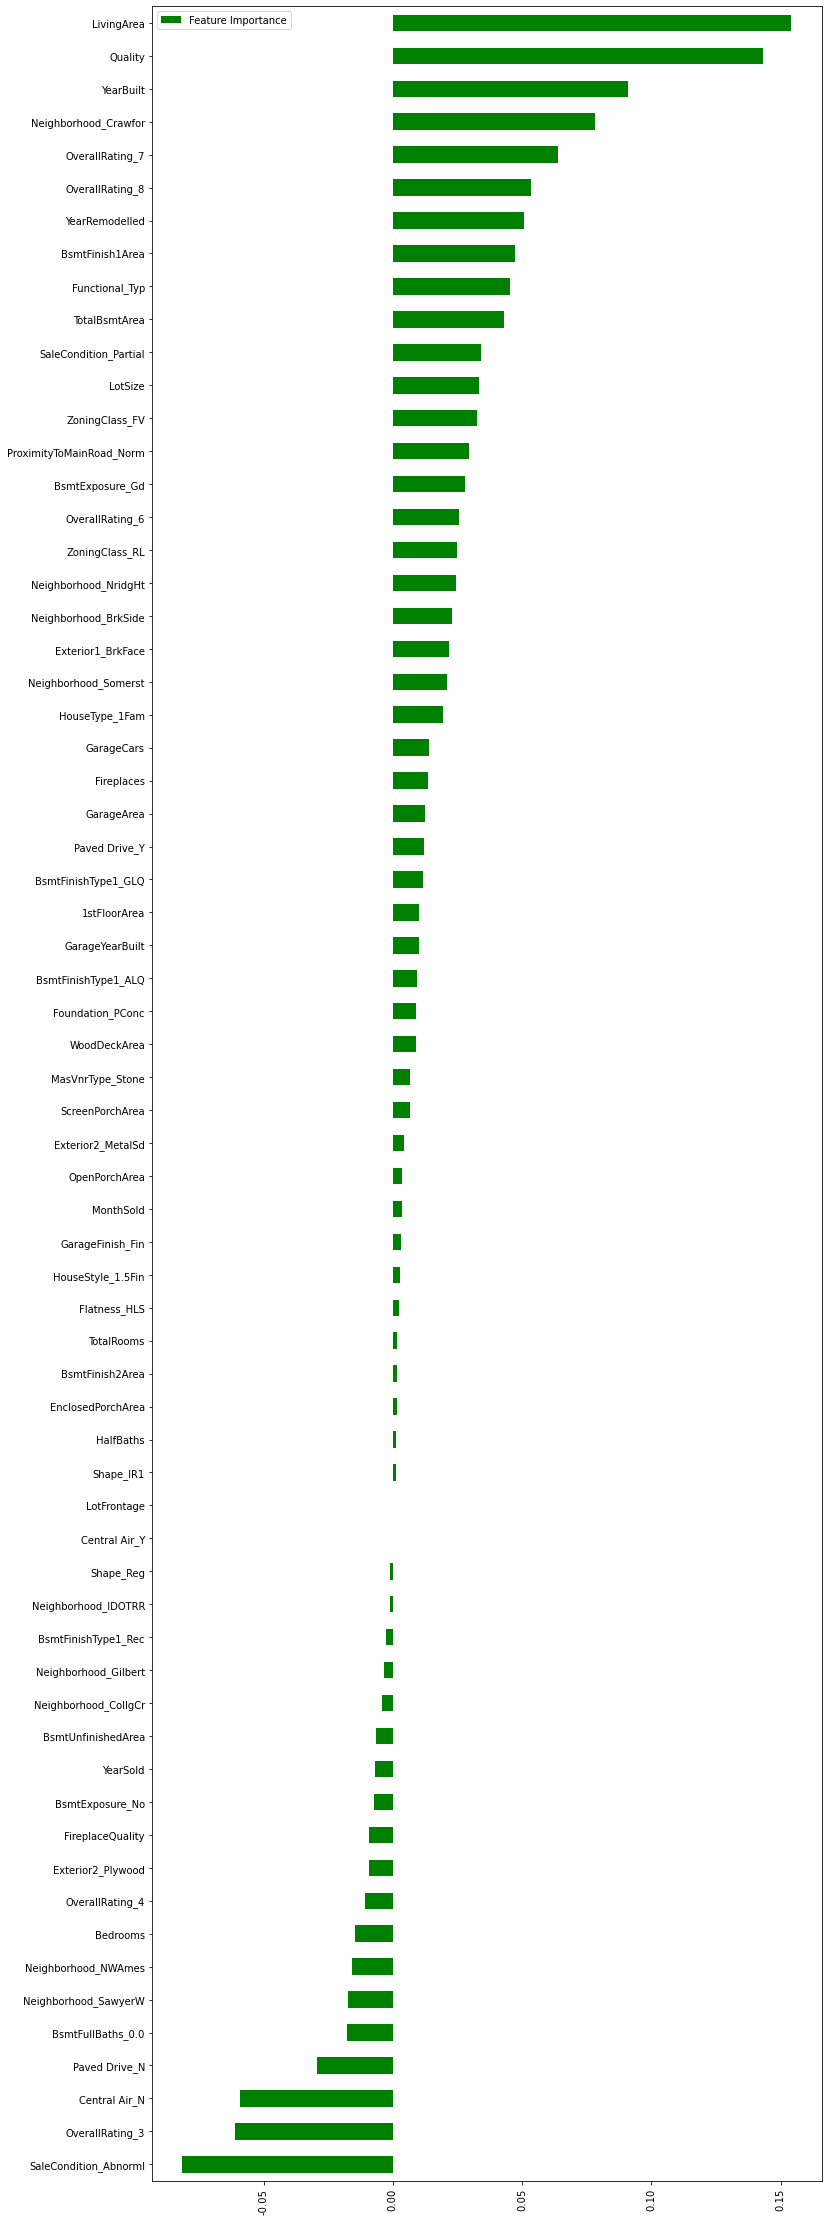

(353, 1)

In [ ]:
## Get the important degree of the feature
FI_lasso[FI_lasso["Feature Importance"] !=0 ].sort_values("Feature Importance").plot(kind="barh",figsize=(12,40), color='g')
plt.xticks(rotation=90)
plt.show()                     

FI_index = FI_lasso.index
FI_val = FI_lasso["Feature Importance"].values
FI_lasso = pd.DataFrame(FI_val, columns = ['Feature Importance'], index = FI_index)
display(FI_lasso.shape)

In [ ]:
choose_cols = FI_lasso.index.tolist()
choose_cols.append("SalePrice")
choose_data = all_data[choose_cols].copy()
del all_data

# Train Our data

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import math
def get_mse(records_real, records_predict):
    
    if len(records_real) == len(records_predict):
        return sum([(x - y) ** 2 for x, y in zip(records_real, records_predict)]) / len(records_real)
    else:
        return None

def get_rmse(records_real, records_predict):

    mse = get_mse(records_real, records_predict)
    if mse:
        return math.sqrt(mse)
    else:
        return None


def rmse_cv(model,X,y):

    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))   
    return rmse

# Main component analysis

In [ ]:
#Scalar the model
y_train, x_train, x_test = split_data(choose_data, index_train)
scaler = RobustScaler()
x_train = scaler.fit(x_train).transform(x_train)  
x_test = scaler.transform(x_test)               
y_train = y_train.values.reshape(-1,1)

In [ ]:
pca_model = PCA(n_components=353)
x_train = pca_model.fit_transform(x_train)
x_test = pca_model.transform(x_test)

# Cross-Validation

In [ ]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [ ]:
param_grid = {'alpha': [0.0004,0.0005,0.0006,0.0007,0.0008,0.0009],'max_iter':[10000],'random_state':[1]}
grid(Lasso()).grid_get(x_train, y_train, param_grid)

{'alpha': 0.0004, 'max_iter': 10000, 'random_state': 1} 0.10277819621609563
                                              params  mean_test_score  \
0  {'alpha': 0.0004, 'max_iter': 10000, 'random_s...         0.102778   
1  {'alpha': 0.0005, 'max_iter': 10000, 'random_s...         0.103440   
2  {'alpha': 0.0006, 'max_iter': 10000, 'random_s...         0.104035   
3  {'alpha': 0.0007, 'max_iter': 10000, 'random_s...         0.104581   
4  {'alpha': 0.0008, 'max_iter': 10000, 'random_s...         0.105199   
5  {'alpha': 0.0009, 'max_iter': 10000, 'random_s...         0.105740   

   std_test_score  
0        0.000386  
1        0.000384  
2        0.000394  
3        0.000422  
4        0.000461  
5        0.000509  


In [ ]:
param_grid = {'alpha':[35,40,45,50,55,60,65,70,80,90]}
grid(Ridge()).grid_get(x_train, y_train, param_grid)

{'alpha': 35} 0.10243087302501518
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.102431        0.000501
1  {'alpha': 40}         0.102733        0.000499
2  {'alpha': 45}         0.103032        0.000500
3  {'alpha': 50}         0.103327        0.000503
4  {'alpha': 55}         0.103620        0.000509
5  {'alpha': 60}         0.103908        0.000516
6  {'alpha': 65}         0.104193        0.000524
7  {'alpha': 70}         0.104475        0.000532
8  {'alpha': 80}         0.105029        0.000552
9  {'alpha': 90}         0.105572        0.000572


In [ ]:
param_grid = {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}
grid(SVR()).grid_get(x_train, y_train, param_grid)

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10096744192066813
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.102244   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.101523   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.102235   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.101497   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.101957   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.101369   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.101979   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.101360   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.101789   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.101248   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.101769   
11  {'C': 13, 'epsilon': 0.009

In [ ]:
param_grid = {'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}#定义好的参数，用字典来表示
grid(KernelRidge()).grid_get(x_train, y_train, param_grid)

{'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.09936953214205793
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.100956   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.099937   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.099370   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.102323   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.100915   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.100104   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.103579   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.101807   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.100794   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.104770   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.102635   
11  {'alpha': 0.5, 'coef0'

In [ ]:
param_grid = {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000],'random_state':[3]}
grid(ElasticNet()).grid_get(x_train, y_train, param_grid)

{'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter': 10000, 'random_state': 3} 0.10137501134980367
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.102630   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.102382   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.101375   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.101734   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.102435   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.101823   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.101586   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.101692   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.102818   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.103847   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.102541   
11  {'alpha': 0.004

In [ ]:
#Grid Search to find out the optimal hyperparameter
lasso = Lasso(alpha=0.0004,random_state=1,max_iter=10000)
ridge = Ridge(alpha=35)
svr = SVR(gamma= 0.0004,kernel='rbf',C=15,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=1.2)
ela = ElasticNet(alpha=0.0005,l1_ratio=0.3,random_state=3,max_iter=10000)
bay = BayesianRidge()

xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.05, max_depth=3,
                   min_child_weight=1.7817, n_estimators=2200,reg_alpha=0.4640, 
                   reg_lambda=0.8571,subsample=0.5213, silent=0,random_state =7, nthread = -1)

lgbm = LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=700,max_bin = 55,
                     bagging_fraction = 0.8,bagging_freq = 5, feature_fraction = 0.25,feature_fraction_seed=9, 
                     bagging_seed=9,min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

GBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

# Stacking Process

In [ ]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod                                               
        self.meta_model = meta_model                                 
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)    
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]         
        oof_train = np.zeros((X.shape[0], len(self.mod)))      
        
        for i,model in enumerate(self.mod):                   
            for train_index, val_index in self.kf.split(X,y): 
                renew_model = clone(model)                   
                renew_model.fit(X[train_index], y[train_index])           
                self.saved_model[i].append(renew_model)                 
                
                val_prediction = renew_model.predict(X[val_index]).reshape(-1,1)  
                
                for temp_index in range(val_prediction.shape[0]):
                    oof_train[val_index[temp_index],i] = val_prediction[temp_index] 
                
        self.meta_model.fit(oof_train,y)                       
        return self
    
   
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model])        
        return self.meta_model.predict(whole_test)                    
    
 
    def get_oof(self,X,y,test_X):                 
        oof = np.zeros((X.shape[0],len(self.mod)))            
        test_single = np.zeros((test_X.shape[0],5))               
        #display(test_single.shape)
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):                     
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):          
                clone_model = clone(model)                                           
                clone_model.fit(X[train_index],y[train_index])                     
                
                val_prediction = clone_model.predict(X[val_index]).reshape(-1,1)    
                for temp_index in range(val_prediction.shape[0]):
                    oof[val_index[temp_index],i] = val_prediction[temp_index]        
                    
             
                
                test_prediction = clone_model.predict(test_X).reshape(-1,1)         
                
                
                test_single[:,j] = test_prediction[:,0]
            test_mean[:,i] = test_single.mean(axis=1)                                
        return oof, test_mean

In [ ]:
#Define stacking model and evaluate
stack_model = stacking(mod=[ela,svr,bay,lasso,ridge,ker], meta_model=ker)

x_train = SimpleImputer().fit_transform(x_train)
y_train = SimpleImputer().fit_transform(y_train.reshape(-1,1)).ravel()

score = rmse_cv(stack_model,x_train, y_train)   
display(score.mean())

0.09923464173088473

In [ ]:
#The second learning model
x_train_stack, x_test_stack = stack_model.get_oof(x_train,y_train,x_test)

In [ ]:
x_train_add = np.hstack((x_train,x_train_stack))
x_test_add = np.hstack((x_test,x_test_stack))

In [ ]:
score = rmse_cv(stack_model,x_train_add,y_train)
print(score.mean())

0.09757169505913406


In [ ]:
#Best hyperparameter
param_grid = {'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]}
grid(Lasso()).grid_get(x_train_add, y_train, param_grid)

{'alpha': 0.0009, 'max_iter': 10000} 0.10116884283923401
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.102272        0.000676
1  {'alpha': 0.0005, 'max_iter': 10000}         0.101873        0.000683
2  {'alpha': 0.0007, 'max_iter': 10000}         0.101336        0.000694
3  {'alpha': 0.0006, 'max_iter': 10000}         0.101534        0.000684
4  {'alpha': 0.0009, 'max_iter': 10000}         0.101169        0.000707
5  {'alpha': 0.0008, 'max_iter': 10000}         0.101229        0.000701


In [ ]:
param_grid = {'alpha':[35,40,45,50,55,60,65,70,80,90]}
grid(Ridge()).grid_get(x_train_add, y_train, param_grid)

{'alpha': 35} 0.10274588072290469
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.102746        0.000580
1  {'alpha': 40}         0.102876        0.000570
2  {'alpha': 45}         0.103004        0.000562
3  {'alpha': 50}         0.103132        0.000557
4  {'alpha': 55}         0.103261        0.000553
5  {'alpha': 60}         0.103391        0.000551
6  {'alpha': 65}         0.103522        0.000549
7  {'alpha': 70}         0.103654        0.000549
8  {'alpha': 80}         0.103923        0.000552
9  {'alpha': 90}         0.104196        0.000556


In [ ]:
param_grid = {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}
grid(SVR()).grid_get(x_train_add, y_train, param_grid)

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10177617593252214
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.103174   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.102535   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.103110   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.102491   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.102997   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.102300   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.102955   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.102287   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.102841   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.102127   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.102823   
11  {'C': 13, 'epsilon': 0.009

In [ ]:
param_grid = {'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
grid(KernelRidge()).grid_get(x_train_add, y_train, param_grid)

{'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.10954893845677433
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.113617   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.111455   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.109549   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.114099   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.112194   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.110507   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.114312   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.112572   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.111034   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.114403   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.112780   
11  {'alpha': 0.5, 'coef0'

In [ ]:
param_grid = {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]}
grid(ElasticNet()).grid_get(x_train_add, y_train, param_grid)

{'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.0949077009914576
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.094908   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.095382   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.101278   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.102781   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.102686   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.097905   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.098643   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.102538   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.102718   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.101837   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.103117   
11  {'alpha': 0.004, 'l1_ratio': 0.1, 

In [ ]:

lasso = Lasso(alpha=0.0009,max_iter=10000)
ridge = Ridge(alpha=35)
svr = SVR(gamma= 0.0004,kernel='rbf',C=15,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=1.2)
ela = ElasticNet(alpha=0.0005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.05, max_depth=3,
                   min_child_weight=1.7817, n_estimators=2200,reg_alpha=0.4640, 
                           reg_lambda=0.8571,subsample=0.5213, silent=False,random_state =7, nthread = -1)

lgbm = LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=700,max_bin = 55,
                     bagging_fraction = 0.8,bagging_freq = 5, feature_fraction = 0.25,feature_fraction_seed=9, 
                     bagging_seed=9,min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

GBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

## stack_model定义
stack_model = stacking(mod=[ela,svr,bay,lasso,GBR,ker], meta_model=ker)

In [ ]:
#the last one
last_x_train_stack, last_x_test_stack = stack_model.get_oof(x_train_add,y_train,x_test_add)

In [ ]:
param_grid = {'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
grid(KernelRidge()).grid_get(last_x_train_stack, y_train, param_grid)

{'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.08459474385811935
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.084708   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.084638   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.084595   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.084919   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.084815   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.084748   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.085099   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.084968   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.084882   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.085253   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.085102   
11  {'alpha': 0.5, 'coef0'

In [ ]:
#do the prediction
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=1.2)
my_model = ker.fit(last_x_train_stack, y_train)
y_pred_stack = np.expm1(my_model.predict(last_x_test_stack))
display(rmse_cv(my_model,last_x_train_stack,y_train).mean())

0.08457857103027314

In [ ]:
y_train_stack = my_model.predict(last_x_train_stack)       # check the RMSE
display(get_rmse(y_train, y_train_stack))

0.08340132405350024

In [ ]:
#using the stacking model
stack_model = stacking(mod=[lgbm,ela,svr,ridge,lasso,bay,xgb,GBR,ker], \
                       meta_model=KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=1.2))
stack_model.fit(x_train_add,y_train)
y_pred_stack = np.exp(stack_model.predict(x_test_add))

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightG

# Using the XGBoost and LightGBM on the basis of Stacking

In [ ]:
#XGBoost
xgb.fit(last_x_train_stack, y_train)

[15:54:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred_xgb = np.expm1(xgb.predict(last_x_test_stack))
display(rmse_cv(xgb,last_x_train_stack,y_train).mean())

[15:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

0.09530664047922752

In [ ]:
y_train_xgb = xgb.predict(last_x_train_stack)
display(get_rmse(y_train, y_train_xgb))

0.08024452299227634

In [ ]:
#LightGBM
lgbm.fit(last_x_train_stack, y_train)

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.25, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=700, num_leaves=5,
              objective='regression')

In [ ]:
y_pred_lgbm = np.expm1(lgbm.predict(last_x_test_stack))
display(rmse_cv(lgbm,last_x_train_stack,y_train).mean())

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightG

0.0969558986080817

In [ ]:
y_pred = (0.7*y_pred_stack)+(0.15*y_pred_xgb)+(0.15*y_pred_lgbm)

# Saving the Result

In [ ]:
ResultData=pd.DataFrame(np.hstack((df_test_ID.values.reshape(-1,1),y_pred_xgb.reshape(-1,1))), index=range(len(y_pred_xgb)), \
                        columns=['Id', 'SalePrice'])
ResultData['Id'] = ResultData['Id'].astype('int')
ResultData.to_csv(r'D:\MasterFinance\Spring Quarter\Python & SQL\FinalProject\Peng s first try.csv',index=False)